### Goal
Using the data collected from existing customers, build a model that will help the marketing team identify potential customers who are relatively more likely to subscribe term deposit and thus increase their hit ratio.

### Attribute information
Input variables:
Bank client data:
1. age: Continuous feature
2. job: Type of job (management, technician, entrepreneur, blue-collar, etc.)
3. marital: marital status (married, single, divorced)
4. education: education level (primary, secondary, tertiary)
5. default: has credit in default?
6. housing: has housing loan?
7. loan: has personal loan?
8. balance in account

Related to previous contact:
9. contact: contact communication type
10. month: last contact month of year
11. day: last contact day of the month
12. duration: last contact duration, in seconds*

Other attributes:
13. campaign: number of contacts performed during this campaign and for this client
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (-1 tells us the person has not been contacted or contact period is beyond 900 days)
15. previous: number of times the client has been contacted before for the last campaign to subscribe term deposit
16. poutcome: outcome of the previous marketing campaign

Output variable (desired target):
17. Target: Tell us has the client subscribed a term deposit. (Yes, No)

### Import libraries and read dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
sns.set(color_codes=True)

from sklearn import set_config
set_config(print_changed_only=False)

In [2]:
bankData = pd.read_csv('bank-full.csv',na_values='unknown')

In [3]:
bankData.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no
5,35,management,married,tertiary,no,231,yes,no,NaN,5,may,139,1,-1,0,NaN,no
6,28,management,single,tertiary,no,447,yes,yes,NaN,5,may,217,1,-1,0,NaN,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,NaN,5,may,380,1,-1,0,NaN,no
8,58,retired,married,primary,no,121,yes,no,NaN,5,may,50,1,-1,0,NaN,no
9,43,technician,single,secondary,no,593,yes,no,NaN,5,may,55,1,-1,0,NaN,no


### Univariate Analysis

In [4]:
bankData.shape

(45211, 17)

There are 45211 rows and 17 columns.

In [5]:
bankData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        44923 non-null  object
 2   marital    45211 non-null  object
 3   education  43354 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    32191 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   8252 non-null   object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### Insights:
1. There are null values in job,education,contact,poutcome.
2. Age,balance,day,duration,campaign,pdays,previous are of int64 type and rest are object.

In [6]:
bankData.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


### Insights:
1. age: Min is 18,max is 95. Mean > Median => slight right skewed.There are outliers.
2. balance: Min is -8019.0 .People can have credit account so negative balance is possible. Max is 102127.Mean > Median => right skewed.There are outliers.But this is bank data which can have outliers.
3. day: Min is 1,max is 31.It is left skewed.
4. duration: Min is 0,max is 4918.Mean > Median => right skewed. There are outliers.
5. campaign:Min is 1,max is 63.Slightly right skewed.There are outliers.
6. pdays:min is -1 (-1 tells us the person has not been contacted or contact period is beyond 900 days).So -1 value is possible. max is 871.Its right skewed.There are outliers.
7. previous: Min is 0 , max is 275.Slightly right skewed.There are outliers.

In [7]:
bankData.isnull().sum() 

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
Target           0
dtype: int64

Null values present in job,education,contact,poutcome.

In [8]:
bankData['Target'].value_counts(normalize=True)*100

no     88.30152
yes    11.69848
Name: Target, dtype: float64

It is imbalanced dataset which will be good in predicting majority class.Means predicting people who will not opt for term deposit.

In [9]:
bankData.nunique()

age            77
job            11
marital         3
education       3
default         2
balance      7168
housing         2
loan            2
contact         2
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        3
Target          2
dtype: int64

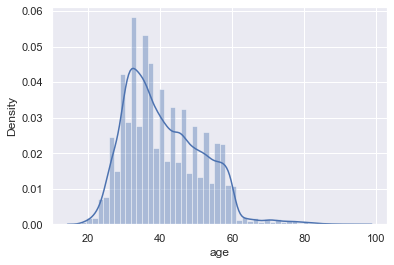

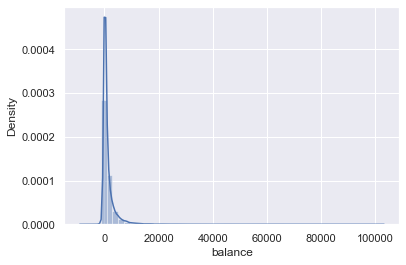

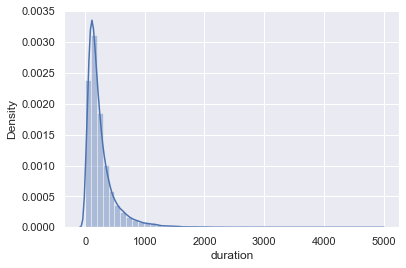

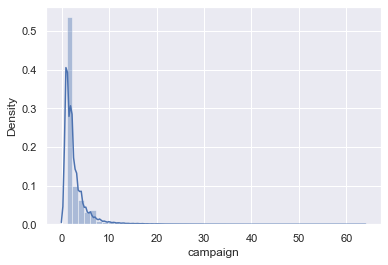

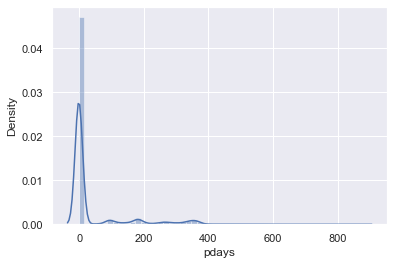

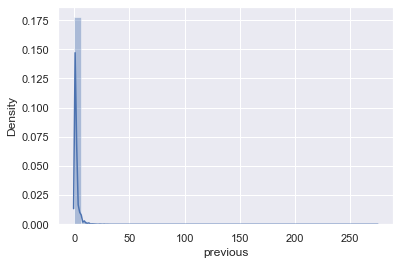

In [10]:
numericalCols = ['age','balance','duration','campaign','pdays','previous']
for i in numericalCols:
    sns.distplot(bankData[i]);
    plt.show()

In [11]:
bankData['campaign'].value_counts()

1     17544
2     12505
3      5521
4      3522
5      1764
6      1291
7       735
8       540
9       327
10      266
11      201
12      155
13      133
14       93
15       84
16       79
17       69
18       51
19       44
20       43
21       35
22       23
23       22
25       22
24       20
28       16
29       16
26       13
31       12
27       10
32        9
30        8
33        6
34        5
36        4
35        4
43        3
38        3
41        2
50        2
37        2
51        1
55        1
46        1
58        1
44        1
39        1
63        1
Name: campaign, dtype: int64

In [12]:
bankData['pdays'].value_counts()

-1      36954
 182      167
 92       147
 183      126
 91       126
        ...  
 749        1
 717        1
 589        1
 493        1
 32         1
Name: pdays, Length: 559, dtype: int64

In [13]:
bankData['previous'].value_counts()

0      36954
1       2772
2       2106
3       1142
4        714
5        459
6        277
7        205
8        129
9         92
10        67
11        65
12        44
13        38
15        20
14        19
17        15
16        13
19        11
23         8
20         8
22         6
18         6
24         5
27         5
29         4
25         4
21         4
30         3
28         2
26         2
37         2
38         2
55         1
40         1
35         1
58         1
51         1
41         1
32         1
275        1
Name: previous, dtype: int64

### Insights
1. age:Most of the customer in this dataset are ranging from 20 to 60.There is a long tail indicating outlier.
2. balance:Most of the customer's balance lie between 0 to 10000.There is a long tail indicating outlier.
3. duration:Duration for most of the people lies between 0 1000.It has a tail indicating outlier.
4. campaign:Most of the people were contacted 1 or 2 times during the campaign.
5. pdays:Most of the people were not either not contacted or contact period is beyond 900 days.
6. previous:Most of the people were not contacted before the last campaign for term deposit.

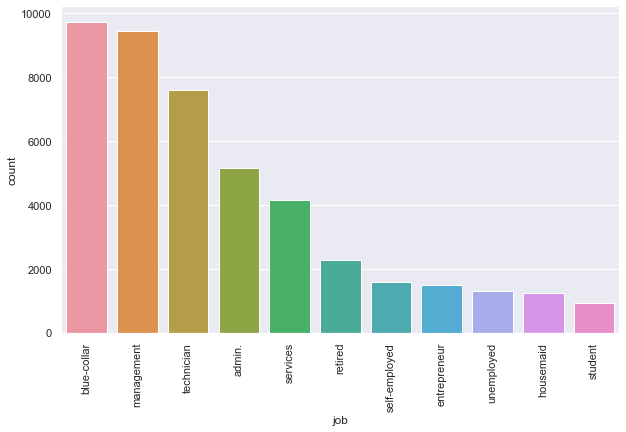

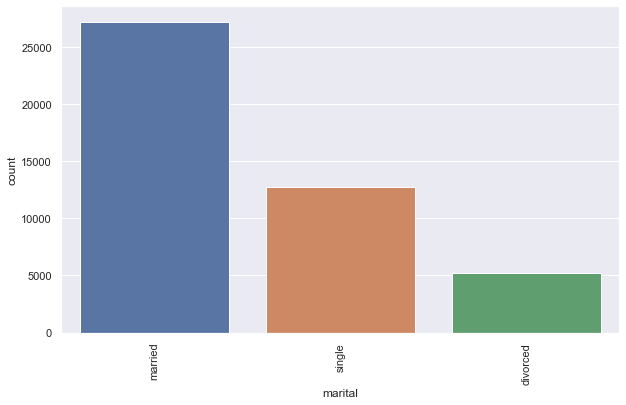

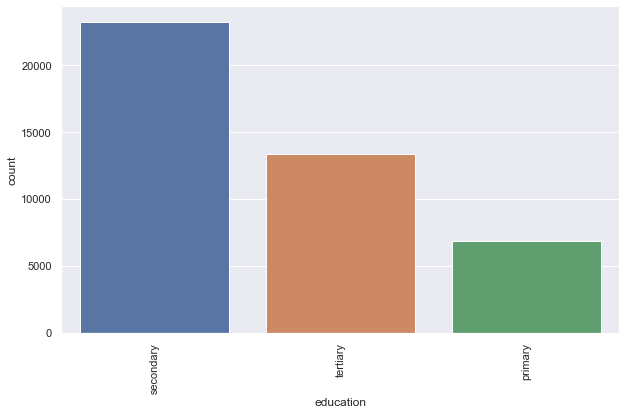

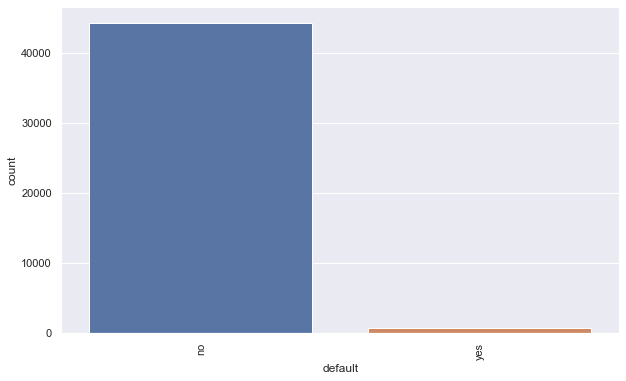

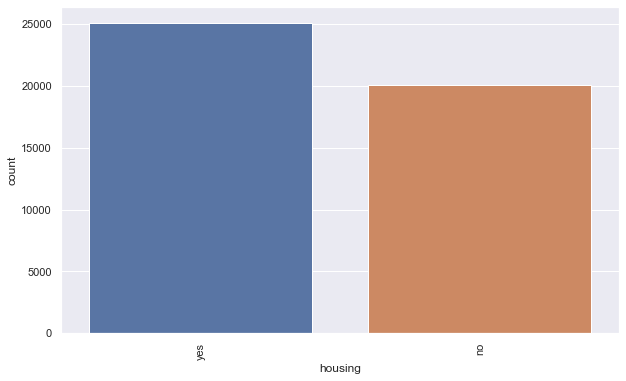

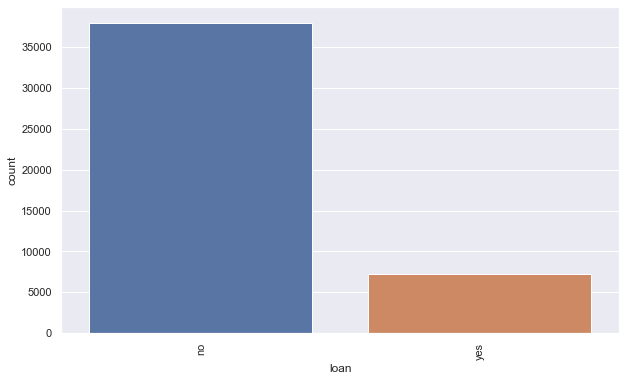

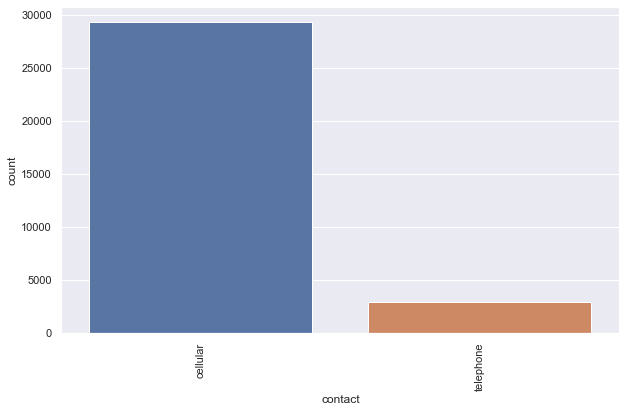

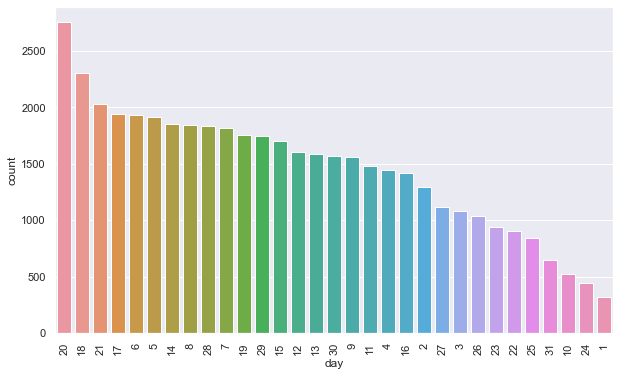

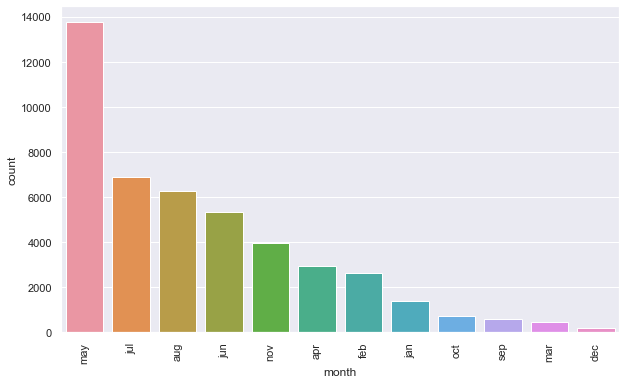

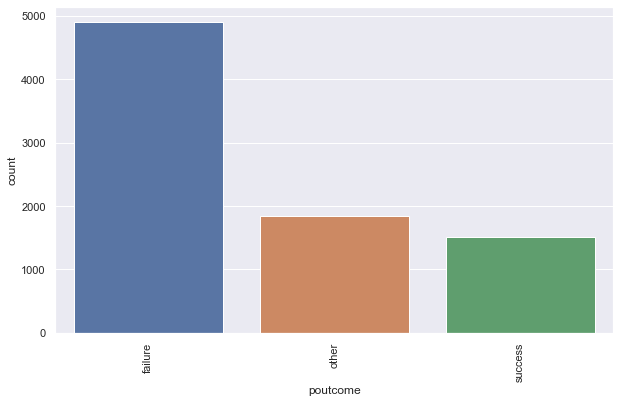

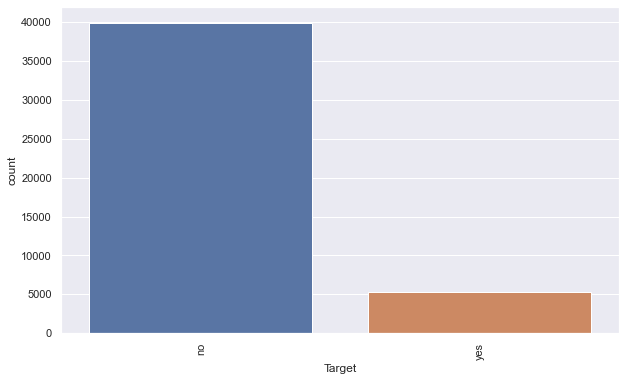

In [14]:
categoricalCols = ['job','marital','education','default','housing','loan','contact','day','month','poutcome','Target']

for i in categoricalCols:
    plt.figure(figsize=(10,6))
    order = bankData[i].value_counts(ascending=False).index
    sns.countplot(bankData[i],order=order)
    plt.xticks(rotation=90)
    plt.show()

### Insights:
1. Maximum no. of people in this dataset are blue-collar followed by management,techician job.
2. Most of the people in this dataset are married.
3. Most of the people have done secondary education followed by tertiary and primary.
4. Mostly all people in this dataset have no default.Only a few have default. Since mostly all people have no default, this will treat as constant column and we can drop it.
5. There are more people who have taken housing loan.
6. More people in this dataset have no personal loan.
7. Most of the people were contacted through cellular.
8. Most of the people were contacted on 20th day of month.
9. Many people were contacted in the May month.
10. There are more failure than success.
11. There are more people who have not taken term deposit.

### Null value treatment

In [15]:
# fill null values for contact and poutcome
imputer = SimpleImputer(missing_values = np.nan,  
                        strategy ='most_frequent')
imputer = imputer.fit(bankData[['contact','poutcome']])
bankData[['contact','poutcome']] = imputer.transform(bankData[['contact','poutcome']])

In [16]:
#binning the age, min is 18,max is 95
bin_edges = [16,36,56,76,96]        
bin_labels = ['16-36', '37-56', '57-76','77-96']              
bankData['age'] = pd.cut(bankData['age'], bins=bin_edges , labels=bin_labels)
bankData['age'] = bankData['age'].cat.codes
bankData['age'].unique()

array([2, 1, 0, 3], dtype=int8)

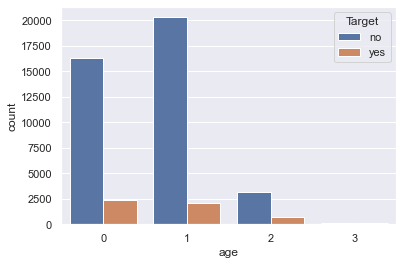

In [17]:
sns.countplot(bankData['age'],hue=bankData['Target']);

In [18]:
bankData['age'].value_counts()

1    22376
0    18713
2     3893
3      229
Name: age, dtype: int64

Since no. of people in age group 3 is very less,let's combine it with age group 2.

In [19]:
bankData['age'] = bankData['age'].replace(3,2)

In [20]:
bankData[bankData['job'].isnull()]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
4,0,NaN,single,NaN,no,1,no,no,cellular,5,may,198,1,-1,0,failure,no
216,1,NaN,married,NaN,no,28,no,no,cellular,5,may,338,2,-1,0,failure,no
354,2,NaN,divorced,NaN,no,27,no,no,cellular,5,may,347,3,-1,0,failure,no
876,1,NaN,single,NaN,no,414,yes,no,cellular,7,may,131,1,-1,0,failure,no
1072,0,NaN,single,primary,no,50,yes,no,cellular,7,may,50,2,-1,0,failure,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44714,1,NaN,married,tertiary,no,406,no,no,cellular,7,sep,314,1,-1,0,failure,yes
44742,2,NaN,married,NaN,no,2799,no,no,telephone,9,sep,378,4,-1,0,failure,no
44970,0,NaN,single,NaN,no,326,no,no,cellular,11,oct,450,1,231,1,success,yes
45141,2,NaN,married,NaN,no,397,no,no,telephone,8,nov,207,1,185,3,success,no


In [21]:
from scipy.stats import mode
df = bankData.groupby(by=['Target','marital','age'])['job'].apply(mode,axis=0)
df

Target  marital   age
no      divorced  0        ([technician], [225])
                  1        ([management], [696])
                  2           ([retired], [211])
        married   0      ([blue-collar], [2171])
                  1      ([blue-collar], [4023])
                  2           ([retired], [969])
        single    0       ([management], [1759])
                  1        ([management], [680])
                  2            ([retired], [45])
yes     divorced  0         ([management], [35])
                  1         ([management], [86])
                  2           ([retired], [106])
        married   0        ([management], [209])
                  1        ([management], [369])
                  2           ([retired], [354])
        single    0        ([management], [386])
                  1         ([management], [89])
                  2            ([retired], [11])
Name: job, dtype: object

In [22]:
#fill null values for job
#Target 'yes'
z = bankData[(bankData['Target']=='yes') & ((bankData['age'] == 0) | (bankData['age'] == 1))]
z['job'] = z['job'].fillna('management')
bankData.update(z)
#All the people in age group 2 irrespective of Target,marital are retired
z = bankData[(bankData['age'] == 2)]
z['job'] = z['job'].fillna('retired')
bankData.update(z)
#Target 'no'
z = bankData[(bankData['Target']=='no') & (bankData['marital'] == 'divorced') & (bankData['age'] == 0)]
z['job'] = z['job'].fillna('technician')
bankData.update(z)
z = bankData[(bankData['Target']=='no') & (bankData['marital'] == 'divorced') & (bankData['age'] == 1)]
z['job'] = z['job'].fillna('management')
bankData.update(z)

z = bankData[(bankData['Target']=='no') & (bankData['marital'] == 'married') & ((bankData['age'] == 0) | (bankData['age'] == 1))]
z['job'] = z['job'].fillna('blue-collar')
bankData.update(z)

z = bankData[(bankData['Target']=='no') & (bankData['marital'] == 'single') & ((bankData['age'] == 0) | (bankData['age'] == 1))]
z['job'] = z['job'].fillna('management')
bankData.update(z)

In [23]:
bankData['job'].isnull().sum()

0

In [24]:
bankData['education'].value_counts(normalize=True)

secondary    0.535176
tertiary     0.306800
primary      0.158025
Name: education, dtype: float64

In [25]:
bankData[bankData['education'].isnull()]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
3,1.0,blue-collar,married,NaN,no,1506.0,yes,no,cellular,5.0,may,92.0,1.0,-1.0,0.0,failure,no
4,0.0,management,single,NaN,no,1.0,no,no,cellular,5.0,may,198.0,1.0,-1.0,0.0,failure,no
13,2.0,technician,married,NaN,no,71.0,yes,no,cellular,5.0,may,71.0,1.0,-1.0,0.0,failure,no
16,1.0,admin.,single,NaN,no,13.0,yes,no,cellular,5.0,may,98.0,1.0,-1.0,0.0,failure,no
42,2.0,blue-collar,married,NaN,no,104.0,yes,no,cellular,5.0,may,22.0,1.0,-1.0,0.0,failure,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45129,1.0,technician,married,NaN,no,3308.0,no,no,cellular,27.0,oct,171.0,1.0,91.0,2.0,success,yes
45141,2.0,retired,married,NaN,no,397.0,no,no,telephone,8.0,nov,207.0,1.0,185.0,3.0,success,no
45150,2.0,management,married,NaN,no,2352.0,no,no,cellular,8.0,nov,354.0,3.0,188.0,13.0,success,no
45158,0.0,student,single,NaN,no,2321.0,no,no,cellular,9.0,nov,600.0,2.0,99.0,5.0,failure,no


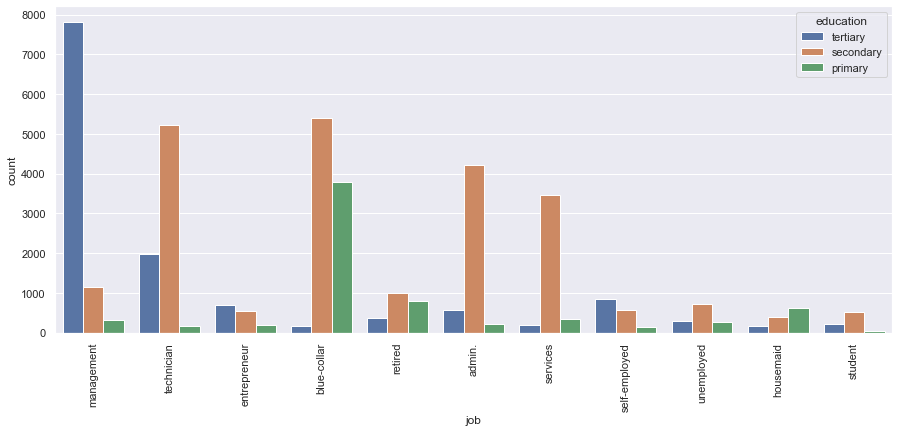

In [26]:
tempDf = bankData[bankData['education'].isnull()]
plt.figure(figsize=(15,6));
sns.countplot(bankData['job'],hue=bankData['education']);
plt.xticks(rotation=90);

### Insights:
1. Most people in jobs Management, entrepreneur,self-employed are tertiary qualified. For rest secondary is the mode.

In [27]:
df1 = bankData.groupby(by=['Target','job','age'])['education'].apply(mode,axis=0)
df1.to_frame()
df1.head(60)

Target  job            age
no      admin.         0.0    ([secondary], [1680])
                       1.0    ([secondary], [1879])
                       2.0     ([secondary], [158])
        blue-collar    0.0    ([secondary], [2409])
                       1.0    ([secondary], [2401])
                       2.0       ([primary], [205])
        entrepreneur   0.0      ([tertiary], [210])
                       1.0      ([tertiary], [389])
                       2.0       ([tertiary], [35])
        housemaid      0.0      ([secondary], [90])
                       1.0       ([primary], [361])
                       2.0       ([primary], [139])
        management     0.0     ([tertiary], [3059])
                       1.0     ([tertiary], [3263])
                       2.0      ([tertiary], [355])
        retired        0.0       ([secondary], [8])
                       1.0     ([secondary], [262])
                       2.0     ([secondary], [520])
        self-employed  0.0      ([ter

In [28]:
df1.tail()

Target  job         age
yes     technician  1.0    ([secondary], [244])
                    2.0     ([secondary], [38])
        unemployed  0.0     ([secondary], [33])
                    1.0     ([secondary], [61])
                    2.0     ([secondary], [14])
Name: education, dtype: object

In [29]:
#blue-collar
z = bankData[(bankData['job'] == 'blue-collar') & (bankData['age'] == 2.0)]
z['education'] = z['education'].fillna('primary')
bankData.update(z)

z = bankData[(bankData['Target'] == 'no') & (bankData['job'] == 'entrepreneur')]
z['education'] = z['education'].fillna('tertiary')
bankData.update(z)
#entrepreneur
z = bankData[(bankData['Target'] == 'yes') & (bankData['job'] == 'entrepreneur') & (bankData['age'] == 0.0)]
z['education'] = z['education'].fillna('tertiary')
bankData.update(z)
#housemaid
z = bankData[(bankData['Target'] == 'no') & (bankData['job'] == 'housemaid') & ((bankData['age'] == 1.0) | (bankData['age'] == 2.0))]
z['education'] = z['education'].fillna('primary')
bankData.update(z)

z = bankData[(bankData['Target'] == 'yes') & (bankData['job'] == 'housemaid') & (bankData['age'] == 0.0)]
z['education'] = z['education'].fillna('tertiary')
bankData.update(z)

z = bankData[(bankData['Target'] == 'yes') & (bankData['job'] == 'housemaid') & (bankData['age'] == 2.0)]
z['education'] = z['education'].fillna('primary')
bankData.update(z)
#management
z = bankData[bankData['job'] == 'management']
z['education'] = z['education'].fillna('tertiary')
bankData.update(z)
#retired
z = bankData[(bankData['Target'] == 'yes') & (bankData['job'] == 'retired') & (bankData['age'] == 0.0)]
z['education'] = z['education'].fillna('primary')
bankData.update(z)
#self-employed
z = bankData[(bankData['Target'] == 'no') & (bankData['job'] == 'self-employed') & ((bankData['age'] == 0.0) | (bankData['age'] == 2.0))]
z['education'] = z['education'].fillna('primary')
bankData.update(z)

z = bankData[(bankData['Target'] == 'yes') & (bankData['job'] == 'self-employed')]
z['education'] = z['education'].fillna('tertiary')
bankData.update(z)

In [30]:
bankData['education'].fillna('secondary',inplace=True)

In [31]:
bankData.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

### Bivariate Analysis

In [32]:
bankData['Target'].replace({'no':0,'yes':1},inplace=True)

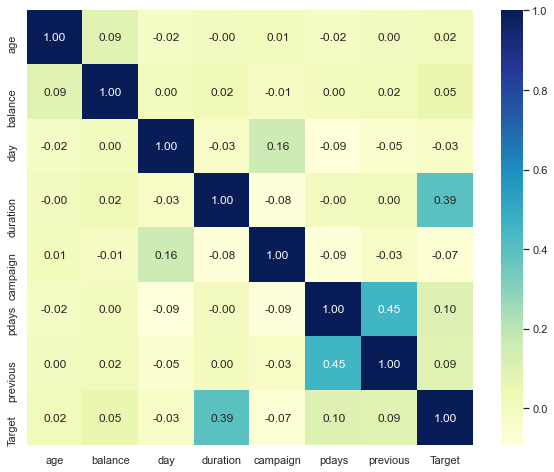

In [33]:
plt.figure(figsize=(10,8))
sns.heatmap(bankData.corr(),annot=True,fmt='.2f',cmap="YlGnBu");

### Insights:
1. Out of all features,duration is most correlated with Target,followed by pdays and previous.
2. pdays and previous are also highly correlated with each other. So we can drop one of them.We will drop previous.
3. Also balance and age are correlated.We can keep only one.So we can drop age.
4. campaign and day are also correlated.We can keep one of them. We can drop campaign.

Lets also see the variation of numerical columns with Target using plots.

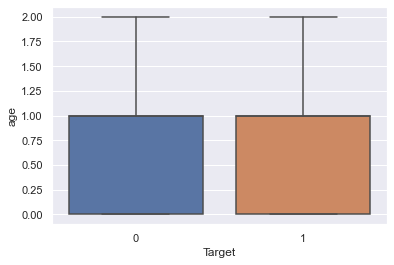

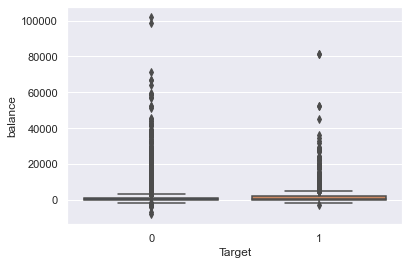

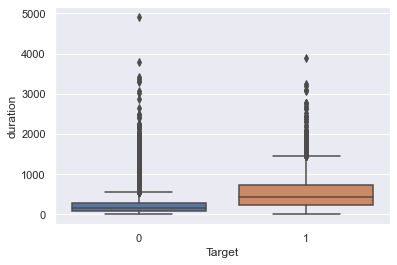

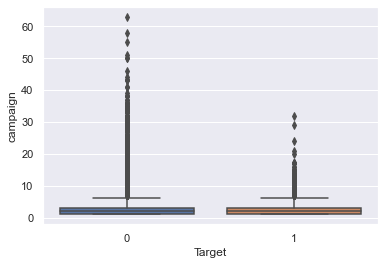

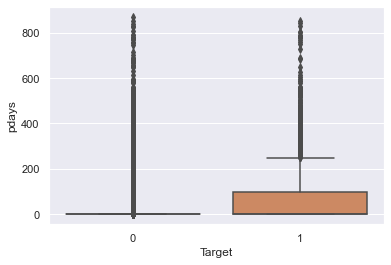

In [34]:
numericalCols = ['age','balance','duration','campaign','pdays']
for i in numericalCols:
    sns.boxplot(x=bankData['Target'],y=bankData[i])
    plt.show()

### Insights:
1. age: It has same distribution.It doesn't look like that it has relation with Target.
2. balance: balance of the people who opted for Term deposit are more.There are outliers in both categories.
3. duration: People who have opted for Term deposit tend to have more duration.
4. campaign: It has same distribution for both categories of Target showing that campaign doesn't have much relation to Target. There are outliers in both categories.
5. pdays: Most of the people were never contacted or conatcted before 900 days.There are outliers in both categories.

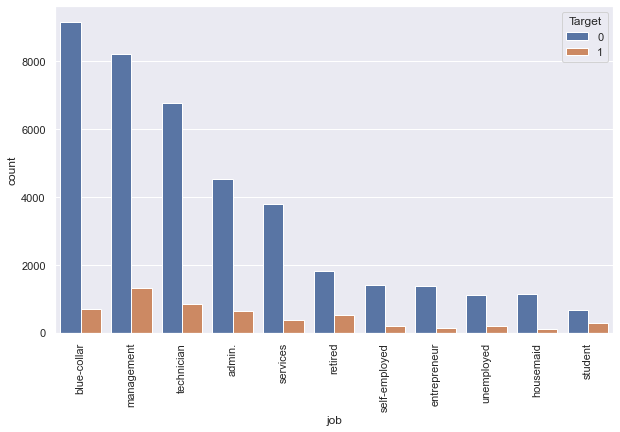

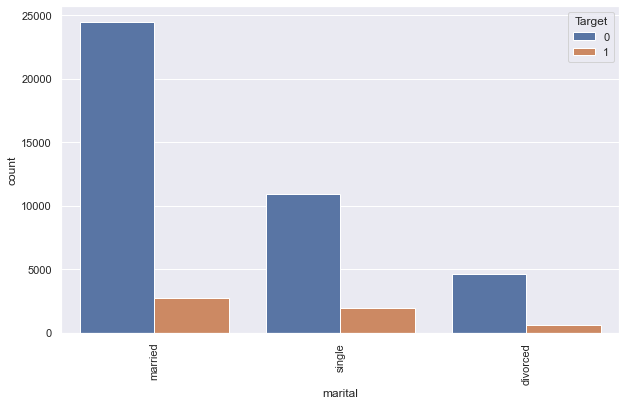

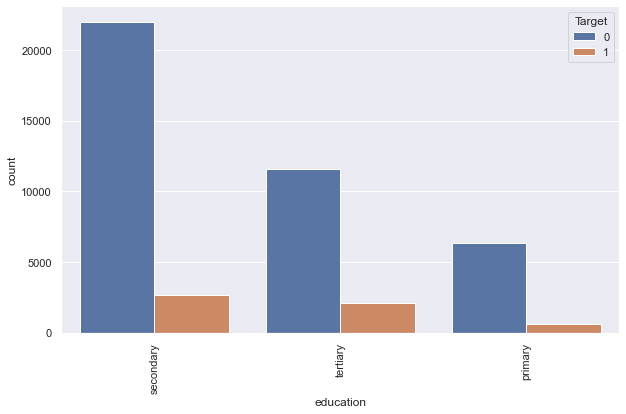

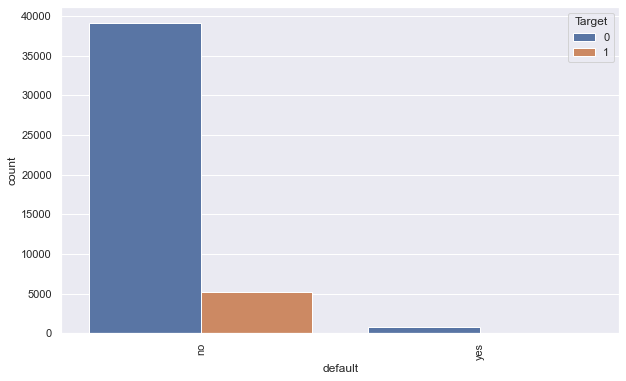

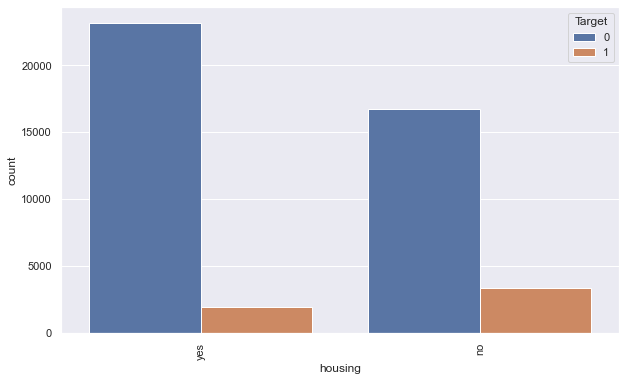

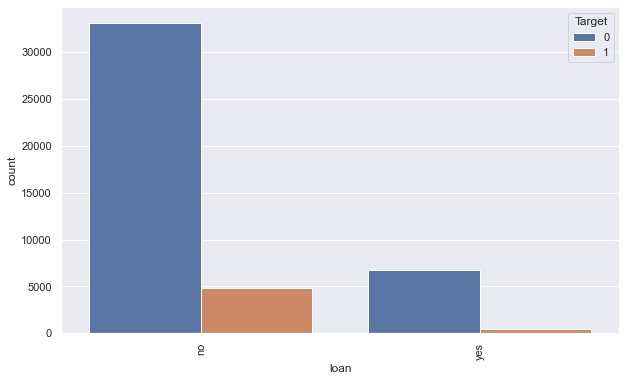

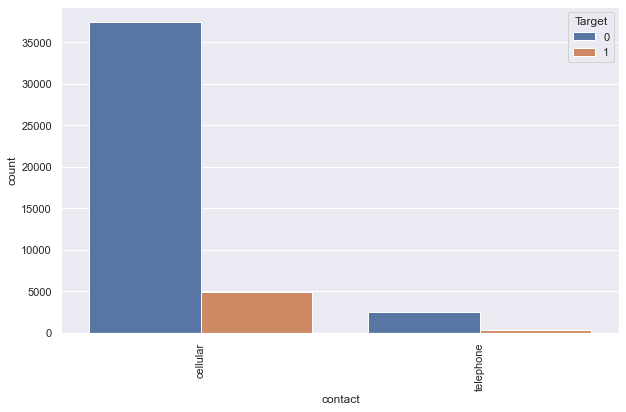

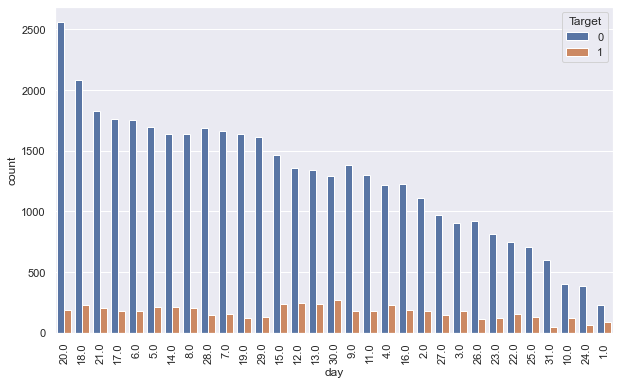

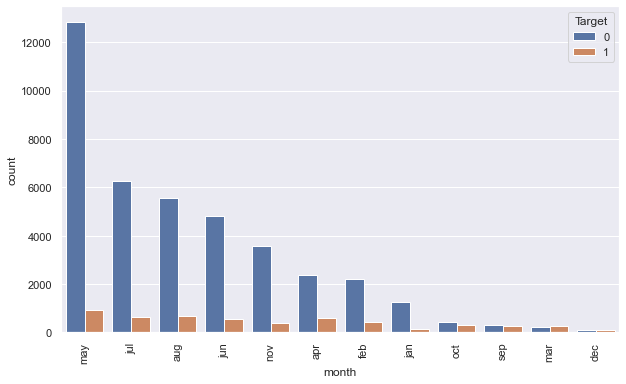

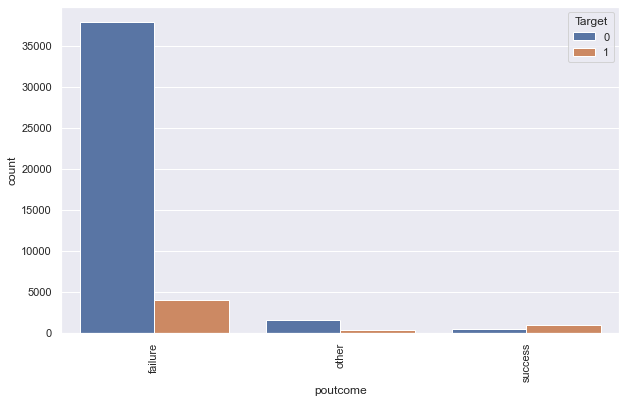

In [35]:
categoricalCols = ['job','marital','education','default','housing','loan','contact','day','month','poutcome']
for i in categoricalCols:
    plt.figure(figsize=(10,6))
    order = bankData[i].value_counts(ascending=False).index
    sns.countplot(bankData[i],hue=bankData['Target'],order=order);
    plt.xticks(rotation=90)
    plt.show()

### Insights:
1. job: People in management job tends to opt for Term deposit, followed by technician,blue-collar.Job seems to be related to Target.
2. marital: More married people have taken term deposit.
3. education: There are more people with secondary education.So they tend to take more term deposit than others.
4. default: People with no default tend to opt for term deposit.
5. housing: People with no housing loan tend to take term plan more than the ones with housing loan.
6. loan: People with no personal loan tend to take term deposit more than others.
7. contact:More people were contacted by cellular.But mode of contact doesn't seems to be related to Target.
8. day: It doesn't look like that day is related to Target.
9. month: People contacted in month of May,April tend to take term deposit more.This seems month has a relation with Target.Like in December there are vacations. So more people are contacted in middle months.
10. poutcome: There are more failures.Outcome of previous campaign is failure but still people took term plan.It doesn't seems to be related to Target.

### Final:
1. Since default and contact acts as constant columns(most of the values are same) and previous,campaign,age are correlated with 
   pdays,day,balance respectively, we can drop them.

In [36]:
modelData = bankData.copy()
modelData.drop(['contact','default','previous','campaign','age'],axis=1,inplace=True)

In [37]:
 # convert object features to categorical
categoricalCols = ['job','marital','education','housing','loan','poutcome','month','Target']
for i in categoricalCols:
    modelData[i] = modelData[i].astype('category') 

In [38]:
X = modelData.drop('Target',axis=1)
y = modelData['Target']

In [39]:
X = pd.get_dummies(X,drop_first=True)

In [40]:
X.head()

,balance,day,duration,pdays,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
0,2143.0,5.0,261.0,-1.0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,29.0,5.0,151.0,-1.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2.0,5.0,76.0,-1.0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1506.0,5.0,92.0,-1.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1.0,5.0,198.0,-1.0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


### Split the data 

In [41]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=7)

### Functions

In [42]:
#function to get evaluation metrics for a model
def evalMetrics(model,actual,predicted,X_train,y_train): 
    print('Training score:',np.round(model.score(X_train,y_train),2))
    print('Testing score:',np.round(accuracy_score(actual,predicted),2))
    print('Precision:',np.round(precision_score(actual,predicted),2))
    print('Recall:',np.round(recall_score(actual,predicted),2))
    print('f1-score:',np.round(f1_score(actual,predicted),2))
    print('==============Classification Report==================')
    print(classification_report(actual,predicted))

In [43]:
# function to get confusion matrix in a proper format
def draw_cm( actual, predicted ):
    cm = confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ['no','yes'] , yticklabels = ['no','yes'])
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

### Logistic Regression

In [44]:
lgModel = LogisticRegression(random_state=7)
lgModel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Training score: 0.89
Testing score: 0.9
Precision: 0.64
Recall: 0.29
f1-score: 0.4
==============Classification Report==================
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     12030
           1       0.64      0.29      0.40      1534

    accuracy                           0.90     13564
   macro avg       0.78      0.63      0.67     13564
weighted avg       0.88      0.90      0.88     13564



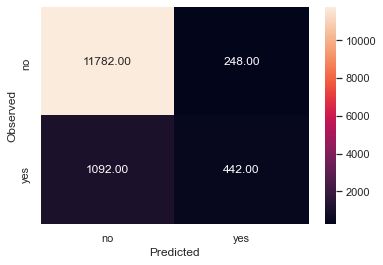

In [45]:
y_pred_lg = lgModel.predict(X_test)
evalMetrics(lgModel,y_test,y_pred_lg,X_train,y_train)
draw_cm(y_test,y_pred_lg)

### Insights:
1. Testing accuracy is better than training accuracy but recall is only 0.29. In this case of identifying potential customers, we should increase recall.
2. From above classification report , we can observe that this model is good in predicting class 0(means people who will not opt for term deposit).
3. Out of 1534 potential customers, we predicted only 442 as right.

### Decision Tree

In [46]:
treeModel = DecisionTreeClassifier(random_state=7)
treeModel.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=7, splitter='best')

Training score: 1.0
Testing score: 0.87
Precision: 0.43
Recall: 0.47
f1-score: 0.45
==============Classification Report==================
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     12030
           1       0.43      0.47      0.45      1534

    accuracy                           0.87     13564
   macro avg       0.68      0.70      0.69     13564
weighted avg       0.88      0.87      0.87     13564



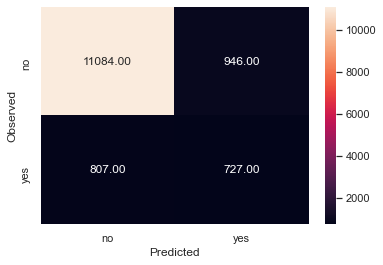

In [47]:
y_pred_dt = treeModel.predict(X_test)
evalMetrics(treeModel,y_test,y_pred_dt,X_train,y_train)
draw_cm(y_test,y_pred_dt)

### Insights:
1. Training score is 1 which implies overfitting.
2. Recall is 0.47 which is better than logistic regression.

### Let's see feature importances

In [48]:
df = pd.DataFrame(treeModel.feature_importances_,columns=['Feature Imp'])
df['Feature'] = X.columns
df.sort_values(by=['Feature Imp'],ascending=False)

,Feature Imp,Feature
2,0.312685,duration
0,0.155575,balance
1,0.111146,day
32,0.096470,poutcome_success
3,0.055130,pdays
18,0.022304,housing_yes
24,0.016357,month_jul
16,0.016238,education_secondary
26,0.015251,month_mar
27,0.013774,month_may


### Random Forest 

In [49]:
random_forest = RandomForestClassifier(n_estimators=80,random_state=42,max_features=9,max_samples=0.8)
random_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=9,
                       max_leaf_nodes=None, max_samples=0.8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Training score: 1.0
Testing score: 0.91
Precision: 0.64
Recall: 0.43
f1-score: 0.51
==============Classification Report==================
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     12030
           1       0.64      0.43      0.51      1534

    accuracy                           0.91     13564
   macro avg       0.79      0.70      0.73     13564
weighted avg       0.90      0.91      0.90     13564



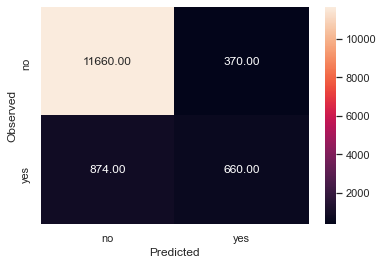

In [50]:
y_pred_rf = random_forest.predict(X_test)
evalMetrics(random_forest,y_test,y_pred_rf,X_train,y_train)
draw_cm(y_test,y_pred_rf)

### BaggingClassifier

In [51]:
bagging_clf = BaggingClassifier(treeModel,random_state=7,n_estimators=45,max_samples=0.7,oob_score=True,n_jobs=-1)
bagging_clf.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=7,
   

Training score: 0.99
Testing score: 0.91
Precision: 0.61
Recall: 0.44
f1-score: 0.51
==============Classification Report==================
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     12030
           1       0.61      0.44      0.51      1534

    accuracy                           0.91     13564
   macro avg       0.77      0.70      0.73     13564
weighted avg       0.89      0.91      0.90     13564



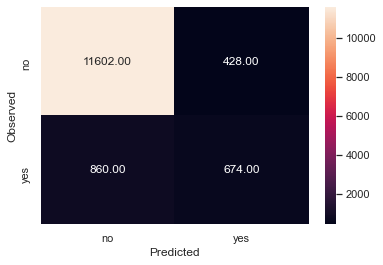

In [52]:
y_pred_bagging = bagging_clf.predict(X_test)
evalMetrics(bagging_clf,y_test,y_pred_bagging,X_train,y_train)
draw_cm(y_test,y_pred_bagging)

### Adaboost 

In [53]:
adaBoost_Model = AdaBoostClassifier(n_estimators=50,random_state=21)
adaBoost_Model.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=21)

Training score: 0.9
Testing score: 0.9
Precision: 0.62
Recall: 0.38
f1-score: 0.47
==============Classification Report==================
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     12030
           1       0.62      0.38      0.47      1534

    accuracy                           0.90     13564
   macro avg       0.77      0.67      0.71     13564
weighted avg       0.89      0.90      0.89     13564



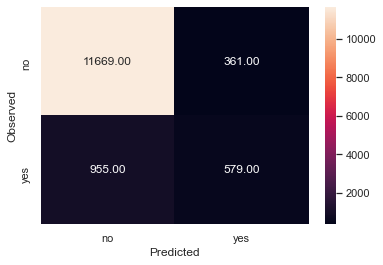

In [54]:
y_pred_ada = adaBoost_Model.predict(X_test)
evalMetrics(adaBoost_Model,y_test,y_pred_ada,X_train,y_train)
draw_cm(y_test,y_pred_ada)

### Gradient Boosting

In [55]:
gb_Model = GradientBoostingClassifier(n_estimators=40,random_state=21,learning_rate=0.6)
gb_Model.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.6, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=40,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=21, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Training score: 0.91
Testing score: 0.91
Precision: 0.62
Recall: 0.44
f1-score: 0.51
==============Classification Report==================
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     12030
           1       0.62      0.44      0.51      1534

    accuracy                           0.91     13564
   macro avg       0.77      0.70      0.73     13564
weighted avg       0.90      0.91      0.90     13564



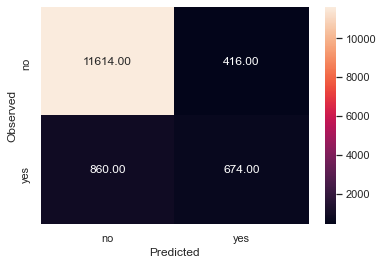

In [56]:
y_pred_gb = gb_Model.predict(X_test)
evalMetrics(gb_Model,y_test,y_pred_gb,X_train,y_train)
draw_cm(y_test,y_pred_gb)

In [57]:
#Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.DataFrame({'Method':['Logistic Regression','Decision Tree','Random Forest','Bagging Classifier','AdaBoost','Gradient Boost'], 
                          'Accuracy': [np.round(accuracy_score(y_test,y_pred_lg),2),
                                       np.round(accuracy_score(y_test,y_pred_dt),2),
                                       np.round(accuracy_score(y_test,y_pred_rf),2),
                                       np.round(accuracy_score(y_test,y_pred_bagging),2),
                                       np.round(accuracy_score(y_test,y_pred_ada),2),
                                       np.round(accuracy_score(y_test,y_pred_gb),2)],
                          'Recall': [np.round(recall_score(y_test,y_pred_lg),2),
                                     np.round(recall_score(y_test,y_pred_dt),2),
                                     np.round(recall_score(y_test,y_pred_rf),2),
                                     np.round(recall_score(y_test,y_pred_bagging),2),
                                     np.round(recall_score(y_test,y_pred_ada),2),
                                     np.round(recall_score(y_test,y_pred_gb),2)],
                         'Precision': [np.round(precision_score(y_test,y_pred_lg),2),
                                       np.round(precision_score(y_test,y_pred_dt),2),
                                       np.round(precision_score(y_test,y_pred_rf),2),
                                       np.round(precision_score(y_test,y_pred_bagging),2),
                                       np.round(precision_score(y_test,y_pred_ada),2),
                                       np.round(precision_score(y_test,y_pred_gb),2)],
                        'f1-score': [np.round(f1_score(y_test,y_pred_lg),2),
                                     np.round(f1_score(y_test,y_pred_dt),2),
                                     np.round(f1_score(y_test,y_pred_rf),2),
                                     np.round(f1_score(y_test,y_pred_bagging),2),
                                     np.round(f1_score(y_test,y_pred_ada),2),
                                     np.round(f1_score(y_test,y_pred_gb),2)] })
resultsDf = resultsDf[['Method', 'Accuracy','Recall','Precision','f1-score']]

resultsDf

,Method,Accuracy,Recall,Precision,f1-score
0,Logistic Regression,0.90,0.29,0.64,0.40
1,Decision Tree,0.87,0.47,0.43,0.45
2,Random Forest,0.91,0.43,0.64,0.51
3,Bagging Classifier,0.91,0.44,0.61,0.51
4,AdaBoost,0.90,0.38,0.62,0.47
5,Gradient Boost,0.91,0.44,0.62,0.51


### Business Insights:
1. In the current scenario of chosing potential customers for term deposit, recall is an important factor. We should work on increasing the recall.
2. From above dataframe, we observe that Gradient Boosting,Bagging Classifier are giving us the best results followed by Random forest. Its accuracy is 91%, recall is 44%.

### Let's try to under sample

In [58]:
from imblearn.under_sampling import RandomUnderSampler

In [59]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [60]:
X_train_rs,X_test_rs,y_train_rs,y_test_rs = train_test_split(X_resampled,y_resampled,test_size=0.3,random_state=7)

### Logistic Regression

In [61]:
lgModel_rs = LogisticRegression(random_state=7)
lgModel_rs.fit(X_train_rs,y_train_rs)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Training score: 0.82
Testing score: 0.81
Precision: 0.82
Recall: 0.8
f1-score: 0.81
==============Classification Report==================
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1593
           1       0.82      0.80      0.81      1581

    accuracy                           0.81      3174
   macro avg       0.81      0.81      0.81      3174
weighted avg       0.81      0.81      0.81      3174



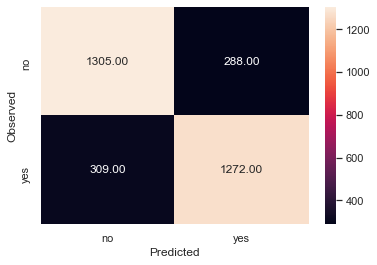

In [62]:
#resampled dataset
pred_lg_rs = lgModel_rs.predict(X_test_rs)
evalMetrics(lgModel_rs,y_test_rs,pred_lg_rs,X_train_rs,y_train_rs)
draw_cm(y_test_rs,pred_lg_rs)

Training score: 0.83
Testing score: 0.83
Precision: 0.38
Recall: 0.81
f1-score: 0.51
==============Classification Report==================
              precision    recall  f1-score   support

           0       0.97      0.83      0.90     12030
           1       0.38      0.81      0.51      1534

    accuracy                           0.83     13564
   macro avg       0.67      0.82      0.70     13564
weighted avg       0.90      0.83      0.85     13564



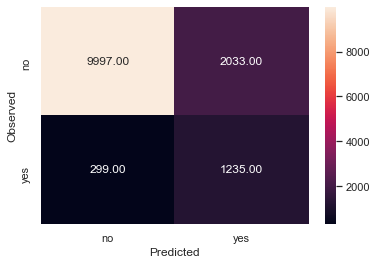

In [63]:
#full dataset
pred_lg_full = lgModel_rs.predict(X_test)
evalMetrics(lgModel_rs,y_test,pred_lg_full,X_train,y_train)
draw_cm(y_test,pred_lg_full)

### Decision Tree

In [64]:
treeModel1 = DecisionTreeClassifier()
treeModel1.fit(X_train_rs,y_train_rs)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Training score: 1.0
Testing score: 0.77
Precision: 0.77
Recall: 0.78
f1-score: 0.77
==============Classification Report==================
              precision    recall  f1-score   support

           0       0.78      0.77      0.77      1593
           1       0.77      0.78      0.77      1581

    accuracy                           0.77      3174
   macro avg       0.77      0.77      0.77      3174
weighted avg       0.77      0.77      0.77      3174



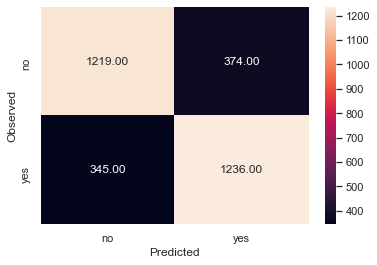

In [65]:
#resampled dataset
pred_dt = treeModel1.predict(X_test_rs)
evalMetrics(treeModel1,y_test_rs,pred_dt,X_train_rs,y_train_rs)
draw_cm(y_test_rs,pred_dt)

Training score: 0.82
Testing score: 0.82
Precision: 0.38
Recall: 0.94
f1-score: 0.54
==============Classification Report==================
              precision    recall  f1-score   support

           0       0.99      0.80      0.89     12030
           1       0.38      0.94      0.54      1534

    accuracy                           0.82     13564
   macro avg       0.69      0.87      0.71     13564
weighted avg       0.92      0.82      0.85     13564



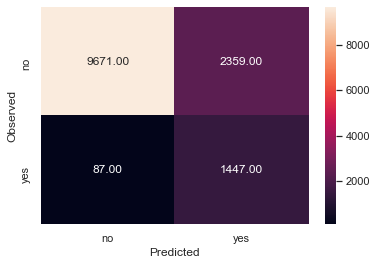

In [66]:
# metrics for full dataset using model created on resampled dataset
pred_dt_full = treeModel1.predict(X_test)
evalMetrics(treeModel1,y_test,pred_dt_full,X_train,y_train)
draw_cm(y_test,pred_dt_full)

### Random Forest

In [67]:
random_forest_rs = RandomForestClassifier(n_estimators=80,random_state=42,max_features=9,max_samples=0.8)
random_forest_rs.fit(X_train_rs,y_train_rs)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=9,
                       max_leaf_nodes=None, max_samples=0.8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Training score: 1.0
Testing score: 0.84
Precision: 0.82
Recall: 0.87
f1-score: 0.84
==============Classification Report==================
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1593
           1       0.82      0.87      0.84      1581

    accuracy                           0.84      3174
   macro avg       0.84      0.84      0.84      3174
weighted avg       0.84      0.84      0.84      3174



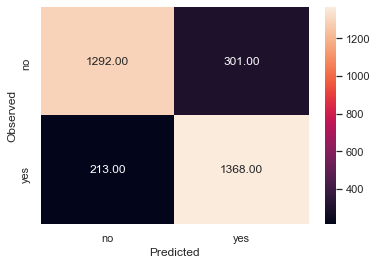

In [68]:
#resampled dataset
pred_rf = random_forest_rs.predict(X_test_rs)
evalMetrics(random_forest_rs,y_test_rs,pred_rf,X_train_rs,y_train_rs)
draw_cm(y_test_rs,pred_rf)


Training score: 0.85
Testing score: 0.85
Precision: 0.43
Recall: 0.97
f1-score: 0.6
==============Classification Report==================
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     12030
           1       0.43      0.97      0.60      1534

    accuracy                           0.85     13564
   macro avg       0.71      0.90      0.75     13564
weighted avg       0.93      0.85      0.87     13564



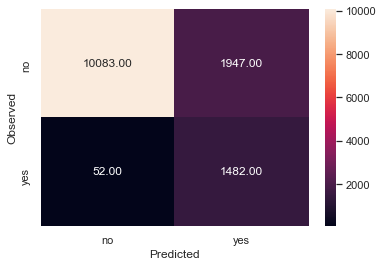

In [69]:
# metrics for full dataset using model created on resampled dataset
pred_rf_full = random_forest_rs.predict(X_test)
evalMetrics(random_forest_rs,y_test,pred_rf_full,X_train,y_train)
draw_cm(y_test,pred_rf_full)

### Bagging Classifier

In [70]:
bagging_clf_rs = BaggingClassifier(treeModel,random_state=7,n_estimators=45,max_samples=0.7,oob_score=True,n_jobs=-1)
bagging_clf_rs.fit(X_train_rs,y_train_rs)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=7,
   

Training score: 0.99
Testing score: 0.84
Precision: 0.82
Recall: 0.87
f1-score: 0.84
==============Classification Report==================
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1593
           1       0.82      0.87      0.84      1581

    accuracy                           0.84      3174
   macro avg       0.84      0.84      0.84      3174
weighted avg       0.84      0.84      0.84      3174



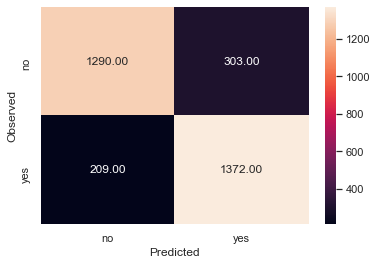

In [71]:
#resampled dataset
pred_bagging_rs = bagging_clf_rs.predict(X_test_rs)
evalMetrics(bagging_clf_rs,y_test_rs,pred_bagging_rs,X_train_rs,y_train_rs)
draw_cm(y_test_rs,pred_bagging_rs)

Training score: 0.85
Testing score: 0.85
Precision: 0.43
Recall: 0.96
f1-score: 0.59
==============Classification Report==================
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     12030
           1       0.43      0.96      0.59      1534

    accuracy                           0.85     13564
   macro avg       0.71      0.90      0.75     13564
weighted avg       0.93      0.85      0.87     13564



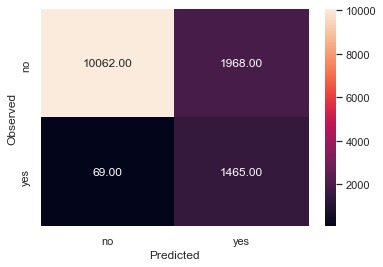

In [72]:
# metrics for full dataset using model created on resampled dataset
pred_bagging_full = bagging_clf_rs.predict(X_test)
evalMetrics(bagging_clf_rs,y_test,pred_bagging_full,X_train,y_train)
draw_cm(y_test,pred_bagging_full)

### Gradient Boosting

In [73]:
gb_Model_rs = GradientBoostingClassifier(n_estimators=40,random_state=21,learning_rate=0.6)
gb_Model_rs.fit(X_train_rs,y_train_rs)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.6, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=40,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=21, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Training score: 0.88
Testing score: 0.83
Precision: 0.82
Recall: 0.85
f1-score: 0.84
==============Classification Report==================
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1593
           1       0.82      0.85      0.84      1581

    accuracy                           0.83      3174
   macro avg       0.83      0.83      0.83      3174
weighted avg       0.83      0.83      0.83      3174



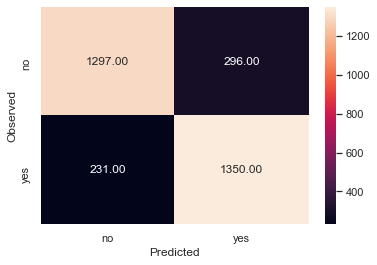

In [74]:
#resampled dataset
pred_gb_rs = gb_Model_rs.predict(X_test_rs)
evalMetrics(gb_Model_rs,y_test_rs,pred_gb_rs,X_train_rs,y_train_rs)
draw_cm(y_test_rs,pred_gb_rs)

Training score: 0.84
Testing score: 0.84
Precision: 0.4
Recall: 0.87
f1-score: 0.55
==============Classification Report==================
              precision    recall  f1-score   support

           0       0.98      0.84      0.90     12030
           1       0.40      0.87      0.55      1534

    accuracy                           0.84     13564
   macro avg       0.69      0.85      0.73     13564
weighted avg       0.92      0.84      0.86     13564



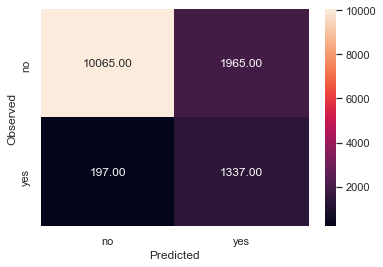

In [75]:
# metrics for full dataset using model created on resampled dataset
pred_gb_full = gb_Model_rs.predict(X_test)
evalMetrics(gb_Model_rs,y_test,pred_gb_full,X_train,y_train)
draw_cm(y_test,pred_gb_full)

In [76]:
resultsDf1 = pd.DataFrame({'Method':['Logistic Regression','Decision Tree','Random Forest','Bagging Classifier','Gradient Boost'], 
                          'Accuracy': [np.round(accuracy_score(y_test,pred_lg_full),2),
                                       np.round(accuracy_score(y_test,pred_dt_full),2),
                                       np.round(accuracy_score(y_test,pred_rf_full),2),
                                       np.round(accuracy_score(y_test,pred_bagging_full),2),
                                       #np.round(accuracy_score(y_test,y_pred_ada),2),
                                       np.round(accuracy_score(y_test,pred_gb_full),2)],
                          'Recall': [np.round(recall_score(y_test,pred_lg_full),2),
                                     np.round(recall_score(y_test,pred_dt_full),2),
                                     np.round(recall_score(y_test,pred_rf_full),2),
                                     np.round(recall_score(y_test,pred_bagging_full),2),
                                     #np.round(recall_score(y_test,y_pred_ada),2),
                                     np.round(recall_score(y_test,pred_gb_full),2)],
                         'Precision': [np.round(precision_score(y_test,pred_lg_full),2),
                                       np.round(precision_score(y_test,pred_dt_full),2),
                                       np.round(precision_score(y_test,pred_rf_full),2),
                                       np.round(precision_score(y_test,pred_bagging_full),2),
                                       #np.round(precision_score(y_test,y_pred_ada),2),
                                       np.round(precision_score(y_test,pred_gb_full),2)],
                        'f1-score': [np.round(f1_score(y_test,pred_lg_full),2),
                                     np.round(f1_score(y_test,pred_dt_full),2),
                                     np.round(f1_score(y_test,pred_rf_full),2),
                                     np.round(f1_score(y_test,pred_bagging_full),2),
                                     #np.round(f1_score(y_test,y_pred_ada),2),
                                     np.round(f1_score(y_test,pred_gb_full),2)
                                     ] })
resultsDf1 = resultsDf1[['Method', 'Accuracy','Recall','Precision','f1-score']]

resultsDf1

,Method,Accuracy,Recall,Precision,f1-score
0,Logistic Regression,0.83,0.81,0.38,0.51
1,Decision Tree,0.82,0.94,0.38,0.54
2,Random Forest,0.85,0.97,0.43,0.60
3,Bagging Classifier,0.85,0.96,0.43,0.59
4,Gradient Boost,0.84,0.87,0.40,0.55


### Insights
Using under sampling, though accuracy has decreased but recall has increased significantly.False positives have also increased but there is no harm in it if we are able to identify more potential customers.
This model can be used(Random Forest- accuracy 0.85, recall-0.97,f1-score: 0.6).